In [26]:
import mysql.connector
from dotenv import load_dotenv
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

import shap

C:\Users\clebe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [44]:
#import scikitplot as skplt

### Importação da base de dados - MySQL database

In [2]:
load_dotenv()

host = os.getenv("DB_HOST")
user = os.getenv("DB_USER")
password = os.getenv("DB_PASSWORD")
database = os.getenv("DB_NAME")

conexao = mysql.connector.connect(
    host=host,
    user=user,
    password=password,
    database=database
)

cursor = conexao.cursor()

paciente = pd.read_sql("SELECT * FROM paciente", conexao)
exame = pd.read_sql("SELECT * FROM exame", conexao)

cursor.close()
conexao.close()

C:\Users\clebe\AppData\Local\Temp\ipykernel_29072\2686424277.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  paciente = pd.read_sql("SELECT * FROM paciente", conexao)
C:\Users\clebe\AppData\Local\Temp\ipykernel_29072\2686424277.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  exame = pd.read_sql("SELECT * FROM exame", conexao)


### Geração da tabela ABT

In [3]:
ABT = pd.merge(exame, paciente, how="inner", on="paciente_id")
ABT = ABT[ABT['tipo_ensaio'] == "Anti-S"]

# Remover "Não informado"
ABT = ABT.replace({'NAO INFORMADO': ''})

# Criação da classe "Target" (0 - incapacidade de neutralização; 1 - capacidade de neutralização)
ABT['grupos'] = np.where(ABT['quantitativo_igg'] >= 5000, 1, 0) 

### Variáveis independentes (features) e dependente (target)

In [4]:
features = ['genero', 'escolaridade_group', 'etnia', "idade_anos",
            'grupo_abo', 'antigeno_abo', 'altura_m', 'regional', 'peso',
            'pulso', 'temperatura_celsius', 'pressao_min', 'pressao_max', 'hemoglobina',
            'num_doses', 'fabricante_dose01', 'fabricante_dose02',
            'fabricante_dose03', 'fabricante_dose04']

X = ABT[features]

y = ABT['grupos']

### OneHotEncoding

In [5]:
X = pd.get_dummies(X, columns=['genero', 'escolaridade_group', 'etnia', 
                               'grupo_abo', 'antigeno_abo', 'regional',
                               'fabricante_dose01', 'fabricante_dose02',
                               'fabricante_dose03', 'fabricante_dose04'])

### Normalização das classes

In [6]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X = pd.DataFrame(X_scaled, columns=X.columns)

# Machine Learning

#### Separação entre grupos

In [10]:
#Treino (train) = 60%
#Validação (eval) = 20%
#Teste (test) = 20% 
# X_train_eval, X_test, y_train_eval, y_test = train_test_split(
#     X, y, random_state=0, test_size=0.20)

# X_train, X_eval, y_train, y_eval = train_test_split(
#     X_train_eval, y_train_eval, random_state=0, test_size=0.25)

# X_train
# X_eval
# X_test

# y_train
# y_eval
# y_test



#Treino (train) = 75%
#Teste (test) = 25% 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size=0.25)

#### Conversões de dados faltantes (utilizei a mediana)

In [11]:
#Treino
X_train['altura_m'] = X_train['altura_m'].fillna(X_train['altura_m'].median())
X_train['peso'] = X_train['peso'].fillna(X_train['peso'].median())
X_train['pulso'] = X_train['pulso'].fillna(X_train['pulso'].median())
X_train['temperatura_celsius'] = X_train['temperatura_celsius'].fillna(X_train['temperatura_celsius'].median())
X_train['pressao_min'] = X_train['pressao_min'].fillna(X_train['pressao_min'].median())
X_train['pressao_max'] = X_train['pressao_max'].fillna(X_train['pressao_max'].median())
X_train['hemoglobina'] = X_train['hemoglobina'].fillna(X_train['hemoglobina'].median())

#Validação
# X_eval['altura_m'] = X_eval['altura_m'].fillna(X_train['altura_m'].median())
# X_eval['peso'] = X_eval['peso'].fillna(X_train['peso'].median())
# X_eval['pulso'] = X_eval['pulso'].fillna(X_train['pulso'].median())
# X_eval['temperatura_celsius'] = X_eval['temperatura_celsius'].fillna(X_train['temperatura_celsius'].median())
# X_eval['pressao_min'] = X_eval['pressao_min'].fillna(X_train['pressao_min'].median())
# X_eval['pressao_max'] = X_eval['pressao_max'].fillna(X_train['pressao_max'].median())
# X_eval['hemoglobina'] = X_eval['hemoglobina'].fillna(X_train['hemoglobina'].median())

#Teste
X_test['altura_m'] = X_test['altura_m'].fillna(X_train['altura_m'].median())
X_test['peso'] = X_test['peso'].fillna(X_train['peso'].median())
X_test['pulso'] = X_test['pulso'].fillna(X_train['pulso'].median())
X_test['temperatura_celsius'] = X_test['temperatura_celsius'].fillna(X_train['temperatura_celsius'].median())
X_test['pressao_min'] = X_test['pressao_min'].fillna(X_train['pressao_min'].median())
X_test['pressao_max'] = X_test['pressao_max'].fillna(X_train['pressao_max'].median())
X_test['hemoglobina'] = X_test['hemoglobina'].fillna(X_train['hemoglobina'].median())

#### Checagens

In [12]:
# Variável resposta é um evento raro?
print("Média-treino:", y_train.mean())
#print("Média-validação:", y_eval.mean())
print("Média-teste:", y_test.mean())

Média-treino: 0.4595423448926634
Média-teste: 0.44798301486199577


In [13]:
# Há dados faltantes?
print("Faltantes-treino: ", X_train.isna().sum().sum())
#print("Faltantes-validação: ", X_eval.isna().sum().sum())
print("Faltantes-teste: ", X_test.isna().sum().sum())

Faltantes-treino:  0
Faltantes-teste:  0


### Modelos

Escolha dos melhores hiperparâmetros (Grid Search)

In [21]:
### Árvore de decisão
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 5, 10, 20, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    DecisionTreeClassifier(),
    param_grid,
    scoring='accuracy',
    cv=StratifiedKFold(n_splits=5),
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

#--------------------
#Randon Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

grid_search_rf = GridSearchCV(
    RandomForestClassifier(),
    param_grid_rf,
    scoring='accuracy',
    cv=StratifiedKFold(n_splits=5),
    verbose=1,
    n_jobs=-1
)

grid_search_rf.fit(X_train, y_train)

#--------------------
#Regressão Logística
param_grid_lr = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['saga'],
    'max_iter': [100, 500]
}

grid_search_lr = GridSearchCV(
    LogisticRegression(),
    param_grid_lr,
    scoring='accuracy',
    cv=StratifiedKFold(n_splits=5),
    verbose=1,
    n_jobs=-1
)

grid_search_lr.fit(X_train, y_train)

#--------------------
# KNN (K-Nearest Neighbors)
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search_knn = GridSearchCV(
    KNeighborsClassifier(),
    param_grid_knn,
    scoring='accuracy',
    cv=StratifiedKFold(n_splits=5),
    verbose=1,
    n_jobs=-1
)

grid_search_knn.fit(X_train, y_train)

#--------------------
# SVM (Support Vector Machine)
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

grid_search_svm = GridSearchCV(
    SVC(),
    param_grid_svm,
    scoring='accuracy',
    cv=StratifiedKFold(n_splits=5),
    verbose=1,
    n_jobs=-1
)

grid_search_svm.fit(X_train, y_train)

#--------------------
# Gradient Boosting Classifier
param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'subsample': [0.8, 1.0],
    'max_features': ['sqrt', 'log2']
}

grid_search_gb = GridSearchCV(
    GradientBoostingClassifier(),
    param_grid_gb,
    scoring='accuracy',
    cv=StratifiedKFold(n_splits=5),
    verbose=1,
    n_jobs=-1
)

grid_search_gb.fit(X_train, y_train)

Fitting 5 folds for each of 405 candidates, totalling 2025 fits
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits


C:\Users\clebe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
80 fits failed out of a total of 160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\clebe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\clebe\AppData\Local\Packages\PythonSoftwareFoundat

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 288 candidates, totalling 1440 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 10],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200], 'subsample': [0.8, 1.0]},
             scoring='accuracy', verbose=1)

In [22]:
print("Melhores hiperparâmetros-Árvore:", grid_search.best_params_)
print("Melhores hiperparâmetros-RF:", grid_search_rf.best_params_)
print("Melhores hiperparâmetros-LR:", grid_search_lr.best_params_)
print("Melhores hiperparâmetros-KNN:", grid_search_knn.best_params_)
print("Melhores hiperparâmetros-SVM:", grid_search_svm.best_params_)
print("Melhores hiperparâmetros-GB:", grid_search_gb.best_params_)

Melhores hiperparâmetros-Árvore: {'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 5}
Melhores hiperparâmetros-RF: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Melhores hiperparâmetros-LR: {'C': 0.1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}
Melhores hiperparâmetros-KNN: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}
Melhores hiperparâmetros-SVM: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Melhores hiperparâmetros-GB: {'learning_rate': 0.01, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200, 'subsample': 0.8}


Treino dos modelos com melhores hiperparametros

In [14]:
# ----------------
# Árvore de Decisão
arvore = DecisionTreeClassifier(
    criterion='gini',
    max_depth=5,
    max_features=None,
    min_samples_leaf=4,
    min_samples_split=5
)
arvore.fit(X_train, y_train)

# ----------------
# Random Forest
random_forest = RandomForestClassifier(
    max_depth=10,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=100
)
random_forest.fit(X_train, y_train)

# ----------------
# Regressão Logística
RL = LogisticRegression(
    C=0.1,
    max_iter=100,
    penalty='l1',
    solver='saga'
)
RL.fit(X_train, y_train)

# ----------------
# KNN (K-Nearest Neighbors)
KNN = KNeighborsClassifier(
    metric='manhattan',
    n_neighbors=11,
    weights='uniform'
)
KNN.fit(X_train, y_train)

# ----------------
# SVM (Support Vector Machine)
SVM = SVC(
    C=10,
    gamma='auto',
    kernel='rbf'
)
SVM.fit(X_train, y_train)

# ----------------
# Gradient Boosting Classifier
GB = GradientBoostingClassifier(
    learning_rate=0.01,
    max_depth=10,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=5,
    n_estimators=200,
    subsample=0.8
)
GB.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, max_depth=10,
                           max_features='sqrt', min_samples_leaf=2,
                           min_samples_split=5, n_estimators=200,
                           subsample=0.8)

Teste dos modelos

In [15]:
y_arvore_predict_test = arvore.predict(X_test)
y_random_forest_predict_test = random_forest.predict(X_test)
y_RL_predict_test = RL.predict(X_test)
y_KNN_predict_test = KNN.predict(X_test)
y_SVM_predict_test = SVM.predict(X_test)
y_GB_predict_test = GB.predict(X_test)

In [ ]:
#Métricas:
arvore_acuracia_test = metrics.accuracy_score(y_test, y_arvore_predict_test)
random_forest_acuracia_test = metrics.accuracy_score(y_test, y_random_forest_predict_test)
RL_acuracia_test = metrics.accuracy_score(y_test, y_RL_predict_test)
KNN_acuracia_test = metrics.accuracy_score(y_test, y_KNN_predict_test)
SVM_acuracia_test = metrics.accuracy_score(y_test, y_SVM_predict_test)
GB_acuracia_test = metrics.accuracy_score(y_test, y_GB_predict_test)

print("Acurácia-Árvore: ", arvore_acuracia_test)
print("Acurácia-Random_Forest: ", random_forest_acuracia_test)
print("Acurácia-Regressao_Logistica: ", RL_acuracia_test)
print("Acurácia-KNN: ", KNN_acuracia_test)
print("Acurácia-SVM: ", SVM_acuracia_test)
print("Acurácia-GB: ", GB_acuracia_test)

Acurácia-Árvore:  0.775654635527247
Acurácia-Random_Forest:  0.7848549186128804
Acurácia-Regressao_Logistica:  0.7763623496107572
Acurácia-KNN:  0.6808209483368719
Acurácia-SVM:  0.775654635527247
Acurácia-GB:  0.7848549186128804


### Curva ROC

In [17]:
y_score_arvore = arvore.predict_proba(X_test)[:, 1]
y_score_random_forest = random_forest.predict_proba(X_test)[:, 1]
y_score_GB = GB.predict_proba(X_test)[:, 1]

### Curva ROC-árvore:
fpr_arvore, tpr_arvore, thresholds = metrics.roc_curve(y_test, y_score_arvore)
arvore_ROC_AUC_test = metrics.roc_auc_score(y_test, y_score_arvore)

print("Área da curva ROC-árvore: ", arvore_ROC_AUC_test)

### Curva ROC-random_forest:
fpr_random_forest, tpr_random_forest, thresholds = metrics.roc_curve(y_test, y_score_random_forest)
random_forest_ROC_AUC_test = metrics.roc_auc_score(y_test, y_score_random_forest)

print("Área da curva ROC-random_forest: ", random_forest_ROC_AUC_test)

### Curva ROC-GB:
fpr_GB, tpr_GB, thresholds = metrics.roc_curve(y_test, y_score_GB)
GB_ROC_AUC_test = metrics.roc_auc_score(y_test, y_score_GB)

print("Área da curva ROC-GB: ", GB_ROC_AUC_test)

Área da curva ROC-árvore:  0.8525013164823592
Área da curva ROC-random_forest:  0.8680520111799732
Área da curva ROC-GB:  0.8687153157532305


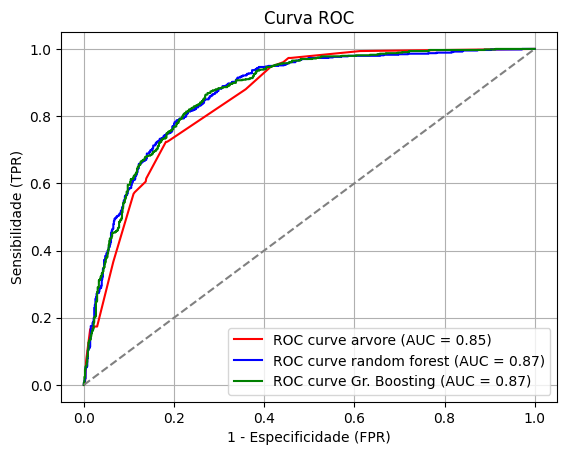

In [21]:
plt.figure()
plt.plot(fpr_arvore, tpr_arvore, color='red', label=f'ROC curve arvore (AUC = {arvore_ROC_AUC_test:.2f})')
plt.plot(fpr_random_forest, tpr_random_forest, color='blue', label=f'ROC curve random forest (AUC = {random_forest_ROC_AUC_test:.2f})')
plt.plot(fpr_GB, tpr_GB, color='green', label=f'ROC curve Gr. Boosting (AUC = {GB_ROC_AUC_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('1 - Especificidade (FPR)')
plt.ylabel('Sensibilidade (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### Curva Lift

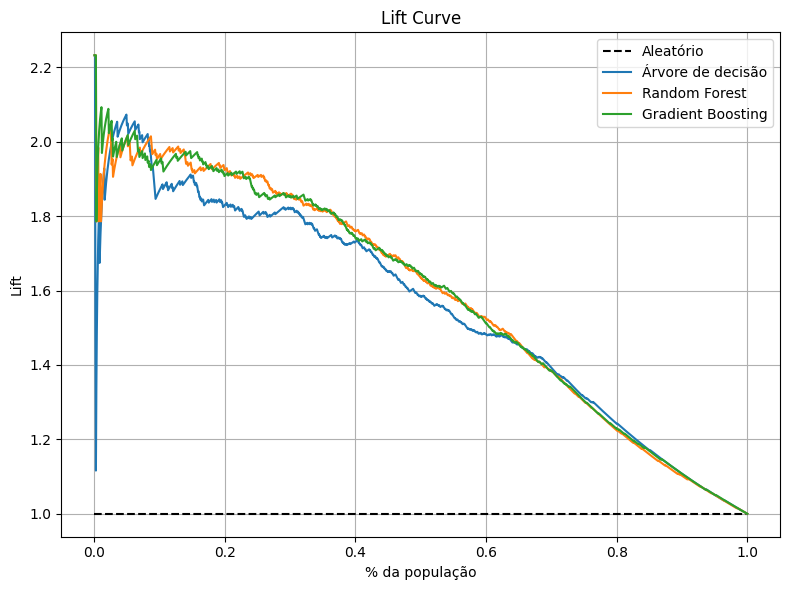

In [22]:
def plot_lift_curve(y_true, y_scores, model_name, ax):
    # Ordena os scores em ordem decrescente
    sorted_indices = np.argsort(y_scores)[::-1]
    y_true_sorted = np.array(y_true)[sorted_indices]
    
    # Calcula a taxa de positivos acumulada
    cumulative_positives = np.cumsum(y_true_sorted)
    
    # Percentual da base analisada
    perc_population = np.arange(1, len(y_true_sorted) + 1) / len(y_true_sorted)
    
    # Lift = % de positivos acumulados / % de positivos esperados aleatoriamente
    lift = cumulative_positives / (np.sum(y_true_sorted) * perc_population)
    
    # Plota curva
    ax.plot(perc_population, lift, label=model_name)
    ax.set_xlabel('% da população')
    ax.set_ylabel('Lift')
    ax.set_title('Lift Curve')
    ax.legend()

# ---------------------------
# Pega as probabilidades do modelo (classe positiva)
y_tree_proba = arvore.predict_proba(X_test)[:, 1]
y_rf_proba = random_forest.predict_proba(X_test)[:, 1]
y_gb_proba = GB.predict_proba(X_test)[:, 1]

fig, ax = plt.subplots(figsize=(8,6))

# Adiciona a linha de referência aleatória uma vez só
ax.plot([0,1], [1,1], 'k--', label='Aleatório')

# Agora plota os modelos
plot_lift_curve(y_test, y_tree_proba, "Árvore de decisão", ax)
plot_lift_curve(y_test, y_rf_proba, "Random Forest", ax)
plot_lift_curve(y_test, y_gb_proba, "Gradient Boosting", ax)

ax.set_xlabel('% da população')
ax.set_ylabel('Lift')
ax.set_title('Lift Curve')
ax.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Importância das features

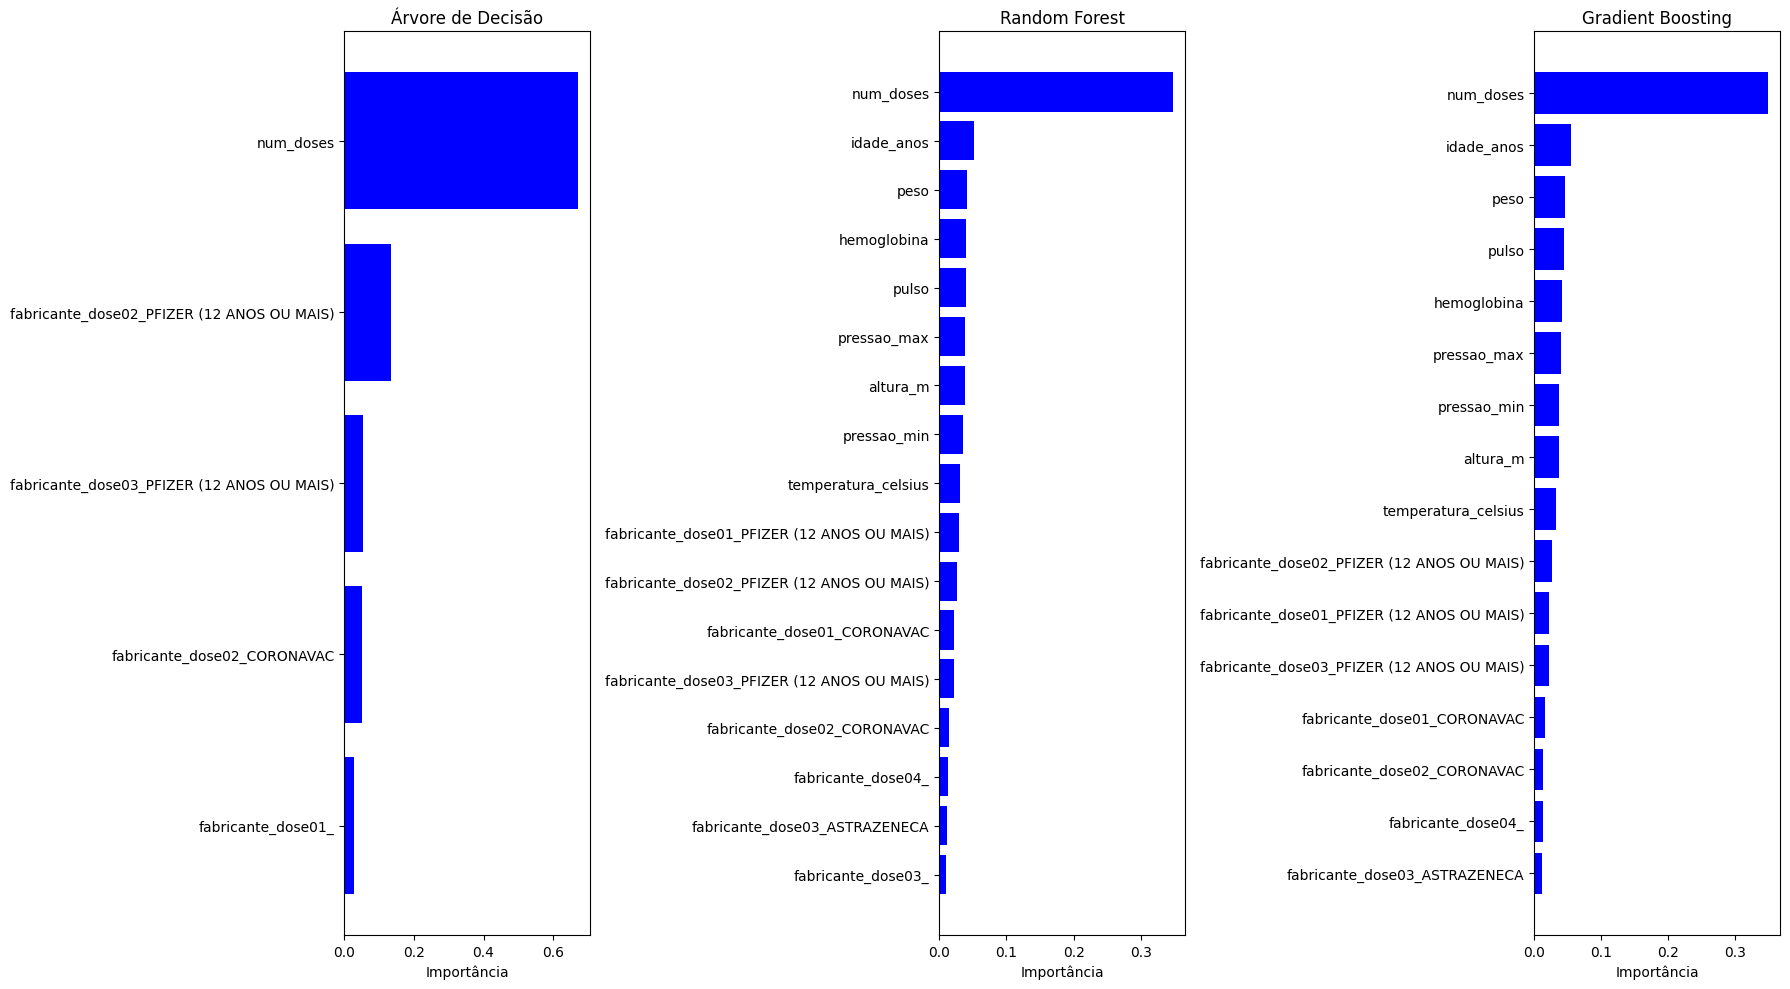

In [30]:
modelos = [
    (arvore, 'Árvore de Decisão'),
    (random_forest, 'Random Forest'),
    (GB, 'Gradient Boosting')
]

feature_names = X.columns

plt.figure(figsize=(18, 10))

for i, (modelo, titulo) in enumerate(modelos, 1):
    importances = modelo.feature_importances_
    
    mask = importances > 0.01
    filtered_importances = importances[mask]
    filtered_feature_names = feature_names[mask]
    
    indices = np.argsort(filtered_importances)
    sorted_importances = filtered_importances[indices]
    sorted_feature_names = filtered_feature_names[indices]

    plt.subplot(1, 3, i)
    plt.barh(range(len(sorted_importances)), sorted_importances, color="b", align="center")
    plt.yticks(range(len(sorted_importances)), sorted_feature_names)
    plt.xlabel("Importância")
    plt.title(titulo)
    plt.tight_layout()

plt.show()

### Métrica de Kolmogorov-Smirnov (KS)

In [20]:
### Considerando Randon Forest como o melhor modelo...

y_test_RF_proba = random_forest.predict_proba(X_test) #Probabilidade de ser 0 (Baixo) ou 1 (Normal)

df = pd.DataFrame({
    'grupos': y_test,
    'RF_model': y_test_RF_proba[:,1]
})

df['grupos'] = df['grupos'].replace({0: 'Baixo', 1: 'Normal'})

#df.to_excel("KS_RF.xlsx", index=False)

### Salvando o modelo

In [44]:
# Séries sobre o modelo
model_s = pd.Series({'Modelo-RF': random_forest,
                     'Features': features,
                     'AUC-Test': random_forest_ROC_AUC_test})

model_s.to_pickle('model_RF.pkl')